In [1]:
%pwd

'C:\\Python\\Books\\Practical-Data-Science-with-Python\\ch02\\segmentation'

In [2]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# Exploring the dataset

## Finding associations between features
The dataset stores info that would help describe each web page visitor. Prior to any deep analysis, one must know relationship between existing features. Any rule or pattern designates a particular relationship.

In [3]:
filepath = r'raw_data\nyt1.csv'
nyt_data = pd.read_csv(filepath)
nyt_data.head()

,Age,Gender,Impressions,Clicks,Signed_In
0,36,0,3,0,1
1,73,1,3,0,1
2,30,0,3,0,1
3,49,1,3,0,1
4,47,1,11,0,1


In [4]:
nyt_data.shape

(458441, 5)

In [5]:
nyt_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458441 entries, 0 to 458440
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   Age          458441 non-null  int64
 1   Gender       458441 non-null  int64
 2   Impressions  458441 non-null  int64
 3   Clicks       458441 non-null  int64
 4   Signed_In    458441 non-null  int64
dtypes: int64(5)
memory usage: 17.5 MB


In [6]:
summary_stat = nyt_data.describe()
summary_stat

,Age,Gender,Impressions,Clicks,Signed_In
count,458441.000000,458441.000000,458441.000000,458441.000000,458441.000000
mean,29.482551,0.367037,5.007316,0.092594,0.700930
std,23.607034,0.481997,2.239349,0.309973,0.457851
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,3.000000,0.000000,0.000000
50%,31.000000,0.000000,5.000000,0.000000,1.000000
75%,48.000000,1.000000,6.000000,0.000000,1.000000
max,108.000000,1.000000,20.000000,4.000000,1.000000


First look at the summary shows that there is a wrong number in _Age_ column, as the minimum age is 0.
It is visible that about 36.7% of users are men.
It is also seen that about 70% of users were signed in.

In [7]:
nyt_data.dtypes

Age            int64
Gender         int64
Impressions    int64
Clicks         int64
Signed_In      int64
dtype: object

_Gender_ and _Signed_In_ columns store boolean values and calculating mean or std makes no sense here. However, it is beneficial for many ML algorithms.

The procedure to make quantitative variables out of qualitative ones is called _making dummy variables_ (`pandas.get_dummies`).

In [8]:
# Make the column types caterogical
nyt_data['Gender'] = nyt_data['Gender'].astype('category')
nyt_data['Signed_In'] = nyt_data['Signed_In'].astype('category')
nyt_data.dtypes

Age               int64
Gender         category
Impressions       int64
Clicks            int64
Signed_In      category
dtype: object

In [9]:
nyt_data['Gender'].describe()

count     458441
unique         2
top            0
freq      290176
Name: Gender, dtype: int64

<AxesSubplot:xlabel='Age', ylabel='Impressions'>

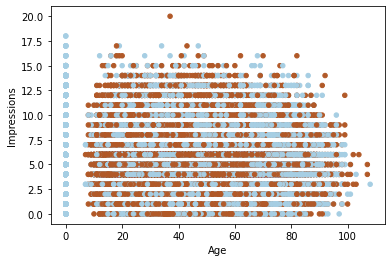

In [10]:
nyt_data.plot(
    kind='scatter',
    x='Age', y='Impressions', c=nyt_data['Gender'],
    colormap='Paired', colorbar=False)

<AxesSubplot:xlabel='Age', ylabel='Clicks'>

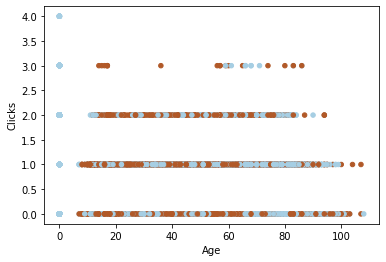

In [11]:
nyt_data.plot(
    kind='scatter',
    x='Age', y='Clicks', c=nyt_data['Gender'],
    colormap='Paired', colorbar=False
)

These simple plots allowed to discover that age zero is not a bare error in data, as all users were designated as females and cover a full range of impressions and clicks.

In [12]:
zero_age_users = nyt_data[nyt_data['Age'] == 0]
zero_age_users.head()

,Age,Gender,Impressions,Clicks,Signed_In
6,0,0,7,1,0
10,0,0,8,1,0
12,0,0,4,0,0
15,0,0,6,0,0
19,0,0,5,0,0


In [13]:
len(zero_age_users) / len(nyt_data)

0.2990701093488584

The users with zero age are about 30% of the entire dataset.

In [14]:
# Check that any user with 0 age is signed in
((nyt_data['Age'] == 0) & (nyt_data['Signed_In'] == 1)).any()

False

In [15]:
# Check that any user with non 0 age is not signed in
((nyt_data['Age'] > 0) & (nyt_data['Signed_In'] == 0)).any()

False

The above output shows that all not signed users have age value of 0, whereas all signed in users have age value more than 0.

## Incorporating custom features
Feature engineering is both art and science that relies on specific knowledge. In the domain of e-commerce, it turned out that click-through rate, demographics (study, gender) and age groups are informative features.

In [16]:
# Create a column that prescribes users with age groups
nyt_data['Age_Group'] = pd.cut(
    nyt_data['Age'],
    bins=[-1, 0, 17, 24, 34, 44, 54, 64, 120],
    labels=['Unknown', '1-17', '18-24', '25-34', '35-44', '45-54', '55-64', '65+']
)
nyt_data.head()

,Age,Gender,Impressions,Clicks,Signed_In,Age_Group
0,36,0,3,0,1,35-44
1,73,1,3,0,1,65+
2,30,0,3,0,1,25-34
3,49,1,3,0,1,45-54
4,47,1,11,0,1,45-54


In [17]:
nyt_data['Age_Group'].dtypes

CategoricalDtype(categories=['Unknown', '1-17', '18-24', '25-34', '35-44', '45-54',
                  '55-64', '65+'],
, ordered=True)

In [18]:
# Create a column that prescribes users with click-through rate
nyt_data['CTR'] = nyt_data['Clicks'] / nyt_data['Impressions']
nyt_data.head()

,Age,Gender,Impressions,Clicks,Signed_In,Age_Group,CTR
0,36,0,3,0,1,35-44,0.0
1,73,1,3,0,1,65+,0.0
2,30,0,3,0,1,25-34,0.0
3,49,1,3,0,1,45-54,0.0
4,47,1,11,0,1,45-54,0.0


A potential zero division error could occur in the operation.

In [19]:
nyt_data['CTR'].isna().sum()

3066

In [20]:
nyt_data['CTR'].isna().sum() / len(nyt_data)

0.006687883500821262

As can be seen, there are 3066 users that have not seen ads. This is about 0.6% of all users, so removing these records would not impact the analysis.

In [21]:
nyt_data.dropna(subset=['CTR'], inplace=True)

In [22]:
any(nyt_data['CTR'] > 1)

False

In [23]:
grouped_by_age = nyt_data.groupby(by='Age_Group').agg(np.mean)

<AxesSubplot:title={'center':'Impressions'}, xlabel='Age_Group'>

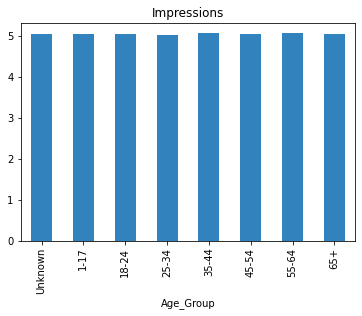

In [24]:
# Visualize distributions of the number of impressions for different age groups
grouped_by_age['Impressions'].plot(
    kind='bar',
    colormap='tab20c',
    title='Impressions'
)

<AxesSubplot:title={'center':'CTR'}, xlabel='Age_Group'>

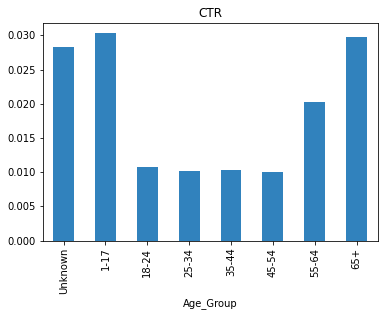

In [25]:
# Visualize distributions of the CTR for different age groups
grouped_by_age['CTR'].plot(
    kind='bar',
    colormap='tab20c',
    title='CTR'
)

In [26]:
grouped_by_age = nyt_data.groupby(by='Age_Group').agg(np.sum)
grouped_by_logged = nyt_data.groupby(by='Signed_In').agg(np.sum)

<AxesSubplot:title={'center':'Clicks'}, xlabel='Age_Group'>

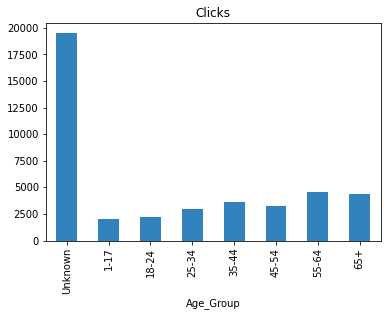

In [27]:
# Visualize number of clicks across age groups
grouped_by_age['Clicks'].plot(
    kind='bar',
    colormap='tab20c',
    title='Clicks'
)

<AxesSubplot:title={'center':'Clicks'}, xlabel='Signed_In'>

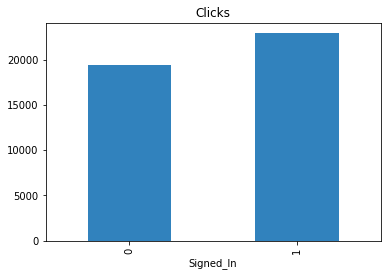

In [28]:
# Visualize number of cliks across signed in status
grouped_by_logged['Clicks'].plot(
    kind='bar',
    colormap='tab20c',
    title='Clicks'
)

In [29]:
def q25(x):
    return x.quantile(0.25)


def q75(x):
    return x.quantile(0.75)


compressed_nyt_data = nyt_data.groupby(
    by=['Age_Group', 'Gender'])[['CTR', 'Clicks']].agg(
    [np.mean, np.std, q25, np.median, q75, np.max, np.sum]
)
compressed_nyt_data

CTR                                               \
                      mean       std  q25 median  q75 amax          sum   
Age_Group Gender                                                          
Unknown   0       0.028355  0.085324  0.0    0.0  0.0  1.0  3861.286179   
          1            NaN       NaN  NaN    NaN  NaN  NaN     0.000000   
1-17      0       0.031786  0.088829  0.0    0.0  0.0  1.0   137.696032   
          1       0.029582  0.087169  0.0    0.0  0.0  1.0   278.070738   
18-24     0       0.010789  0.053556  0.0    0.0  0.0  1.0   203.179856   
          1       0.010685  0.052763  0.0    0.0  0.0  1.0   230.550064   
25-34     0       0.010186  0.049832  0.0    0.0  0.0  1.0   275.541262   
          1       0.010111  0.051750  0.0    0.0  0.0  1.0   310.926682   
35-44     0       0.010234  0.050691  0.0    0.0  0.0  1.0   337.375092   
          1       0.010332  0.051503  0.0    0.0  0.0  1.0   386.720810   
45-54     0       0.010187  0.050994  0.0    0.0  0.0  1.0   306.188140   
          1       0.009754  0.049075  0.0    0.0  0.0  1.0   329.555568   
55-64     0       0.020378  0.072637  0.0    0.0  0.0  1.0   420.446431   
          1       0.020245  0.071184  0.0    0.0  0.0  1.0   482.435216   
65+       0       0.029856  0.084455  0.0    0.0  0.0  1.0   542.879385   
          1       0.029709  0.083338  0.0    0.0  0.0  1.0   308.166585   

                    Clicks                                         
                      mean       std  q25 median  q75 amax    sum  
Age_Group Gender                                                   
Unknown   0       0.143049  0.386644  0.0    0.0  0.0  4.0  19480  
          1            NaN       NaN  NaN    NaN  NaN  NaN      0  
1-17      0       0.157664  0.386004  0.0    0.0  0.0  2.0    683  
          1       0.147021  0.383844  0.0    0.0  0.0  3.0   1382  
18-24     0       0.053207  0.230291  0.0    0.0  0.0  2.0   1002  
          1       0.053995  0.233081  0.0    0.0  0.0  2.0   1165  
25-34     0       0.051310  0.225113  0.0    0.0  0.0  2.0   1388  
          1       0.050374  0.224588  0.0    0.0  0.0  2.0   1549  
35-44     0       0.051782  0.225929  0.0    0.0  0.0  2.0   1707  
          1       0.052232  0.227133  0.0    0.0  0.0  3.0   1955  
45-54     0       0.051303  0.227742  0.0    0.0  0.0  2.0   1542  
          1       0.050018  0.224011  0.0    0.0  0.0  2.0   1690  
55-64     0       0.102026  0.318453  0.0    0.0  0.0  3.0   2105  
          1       0.102854  0.320578  0.0    0.0  0.0  3.0   2451  
65+       0       0.152065  0.384822  0.0    0.0  0.0  3.0   2765  
          1       0.152801  0.386677  0.0    0.0  0.0  3.0   1585

In [30]:
compressed_nyt_data.drop([('Unknown', 1)], inplace=True)
compressed_nyt_data

CTR                                               \
                      mean       std  q25 median  q75 amax          sum   
Age_Group Gender                                                          
Unknown   0       0.028355  0.085324  0.0    0.0  0.0  1.0  3861.286179   
1-17      0       0.031786  0.088829  0.0    0.0  0.0  1.0   137.696032   
          1       0.029582  0.087169  0.0    0.0  0.0  1.0   278.070738   
18-24     0       0.010789  0.053556  0.0    0.0  0.0  1.0   203.179856   
          1       0.010685  0.052763  0.0    0.0  0.0  1.0   230.550064   
25-34     0       0.010186  0.049832  0.0    0.0  0.0  1.0   275.541262   
          1       0.010111  0.051750  0.0    0.0  0.0  1.0   310.926682   
35-44     0       0.010234  0.050691  0.0    0.0  0.0  1.0   337.375092   
          1       0.010332  0.051503  0.0    0.0  0.0  1.0   386.720810   
45-54     0       0.010187  0.050994  0.0    0.0  0.0  1.0   306.188140   
          1       0.009754  0.049075  0.0    0.0  0.0  1.0   329.555568   
55-64     0       0.020378  0.072637  0.0    0.0  0.0  1.0   420.446431   
          1       0.020245  0.071184  0.0    0.0  0.0  1.0   482.435216   
65+       0       0.029856  0.084455  0.0    0.0  0.0  1.0   542.879385   
          1       0.029709  0.083338  0.0    0.0  0.0  1.0   308.166585   

                    Clicks                                         
                      mean       std  q25 median  q75 amax    sum  
Age_Group Gender                                                   
Unknown   0       0.143049  0.386644  0.0    0.0  0.0  4.0  19480  
1-17      0       0.157664  0.386004  0.0    0.0  0.0  2.0    683  
          1       0.147021  0.383844  0.0    0.0  0.0  3.0   1382  
18-24     0       0.053207  0.230291  0.0    0.0  0.0  2.0   1002  
          1       0.053995  0.233081  0.0    0.0  0.0  2.0   1165  
25-34     0       0.051310  0.225113  0.0    0.0  0.0  2.0   1388  
          1       0.050374  0.224588  0.0    0.0  0.0  2.0   1549  
35-44     0       0.051782  0.225929  0.0    0.0  0.0  2.0   1707  
          1       0.052232  0.227133  0.0    0.0  0.0  3.0   1955  
45-54     0       0.051303  0.227742  0.0    0.0  0.0  2.0   1542  
          1       0.050018  0.224011  0.0    0.0  0.0  2.0   1690  
55-64     0       0.102026  0.318453  0.0    0.0  0.0  3.0   2105  
          1       0.102854  0.320578  0.0    0.0  0.0  3.0   2451  
65+       0       0.152065  0.384822  0.0    0.0  0.0  3.0   2765  
          1       0.152801  0.386677  0.0    0.0  0.0  3.0   1585

In [31]:
compressed_nyt_data['Clicks']

mean       std  q25  median  q75  amax    sum
Age_Group Gender                                                   
Unknown   0       0.143049  0.386644  0.0     0.0  0.0   4.0  19480
1-17      0       0.157664  0.386004  0.0     0.0  0.0   2.0    683
          1       0.147021  0.383844  0.0     0.0  0.0   3.0   1382
18-24     0       0.053207  0.230291  0.0     0.0  0.0   2.0   1002
          1       0.053995  0.233081  0.0     0.0  0.0   2.0   1165
25-34     0       0.051310  0.225113  0.0     0.0  0.0   2.0   1388
          1       0.050374  0.224588  0.0     0.0  0.0   2.0   1549
35-44     0       0.051782  0.225929  0.0     0.0  0.0   2.0   1707
          1       0.052232  0.227133  0.0     0.0  0.0   3.0   1955
45-54     0       0.051303  0.227742  0.0     0.0  0.0   2.0   1542
          1       0.050018  0.224011  0.0     0.0  0.0   2.0   1690
55-64     0       0.102026  0.318453  0.0     0.0  0.0   3.0   2105
          1       0.102854  0.320578  0.0     0.0  0.0   3.0   2451
65+       0       0.152065  0.384822  0.0     0.0  0.0   3.0   2765
          1       0.152801  0.386677  0.0     0.0  0.0   3.0   1585